In [1]:
import os
# Change native directory to root
os.chdir(os.path.dirname(os.getcwd()))

In [2]:
import glob
import pandas as pd
import numpy as np
import random
import pickle
from tsfeatures import tsfeatures
import matplotlib.pyplot as plt
import plotly.express as px

# K-mean clustering libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from tqdm import tqdm

random.seed(123)
model_dir = 'models/'

In [3]:
# Read the features from the csv file
features = pd.read_csv('data/social_features.csv', index_col=0)
features

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h22,h23,w0,w1,w2,w3,w4,w5,w6,yearly
411,0.025594,0.025409,0.025116,0.025103,0.025139,0.029776,0.042496,0.054240,0.057699,0.058616,...,0.026282,0.025801,0.166299,0.168422,0.164258,0.165211,0.159204,0.088878,0.087728,15870946.00
1208,0.029063,0.028680,0.028572,0.028642,0.028633,0.029271,0.035419,0.044136,0.051502,0.055081,...,0.031726,0.029920,0.153507,0.153666,0.152658,0.154355,0.148051,0.133553,0.104211,338142.00
588,0.037848,0.034725,0.030499,0.028053,0.025192,0.023478,0.024581,0.027429,0.032357,0.037106,...,0.046429,0.042130,0.151293,0.145897,0.159202,0.132258,0.147747,0.142086,0.121517,187320.45
1116,0.028977,0.025676,0.024056,0.023490,0.023181,0.022967,0.023526,0.024884,0.028833,0.034342,...,0.048883,0.035807,0.132860,0.093873,0.104367,0.098555,0.123614,0.243310,0.203421,34916.35
279,0.035217,0.035691,0.035924,0.036774,0.037489,0.038917,0.041253,0.053402,0.061577,0.060797,...,0.034366,0.034535,0.157889,0.151745,0.150138,0.154060,0.151909,0.116794,0.117466,246941.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1660,0.031519,0.029519,0.026141,0.022525,0.022221,0.023814,0.028086,0.037164,0.051098,0.055678,...,0.042156,0.037928,0.143109,0.145693,0.145230,0.146309,0.148926,0.140697,0.130036,311778.15
642,0.015514,0.015802,0.016082,0.016216,0.017069,0.020507,0.026651,0.037020,0.061349,0.077849,...,0.021696,0.015323,0.168094,0.193132,0.170394,0.180394,0.157494,0.078155,0.052337,648113.40
597,0.038067,0.037521,0.036766,0.036398,0.036318,0.037213,0.039300,0.042130,0.044671,0.046686,...,0.038328,0.038213,0.150509,0.150686,0.150042,0.150256,0.149876,0.125190,0.123440,3236158.00
235,0.028868,0.027834,0.027769,0.027721,0.028707,0.030684,0.036100,0.060162,0.077363,0.074278,...,0.028453,0.028313,0.162106,0.183607,0.189405,0.171302,0.132398,0.082819,0.078364,195611.65


In [4]:
# read metadata csv
metadata = pd.read_csv('data/EANLIJST_METADATA.csv', index_col=0, sep   = ';')
# ADD the functietype column to the features
features['function'] = metadata['Patrimonium Functietype']
# read more metrics from csv
metrics = pd.read_csv('data/ts_metrics.csv', usecols = ['ID', 'mean', 'std'], index_col='ID')
# add the metrics to the features
features = features.join(metrics)
features.isnull().sum()
features.dropna(inplace=True)
features['ID'] = features.index
# drop rows with kast as function
features = features[features['function'] != 'Kast']
features

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,w2,w3,w4,w5,w6,yearly,function,mean,std,ID
1208,0.029063,0.028680,0.028572,0.028642,0.028633,0.029271,0.035419,0.044136,0.051502,0.055081,...,0.152658,0.154355,0.148051,0.133553,0.104211,338142.00,Stadhuis/Gemeentehuis,9.313439,3.516002,1208
588,0.037848,0.034725,0.030499,0.028053,0.025192,0.023478,0.024581,0.027429,0.032357,0.037106,...,0.159202,0.132258,0.147747,0.142086,0.121517,187320.45,Academie,4.929265,4.023414,588
1116,0.028977,0.025676,0.024056,0.023490,0.023181,0.022967,0.023526,0.024884,0.028833,0.034342,...,0.104367,0.098555,0.123614,0.243310,0.203421,34916.35,Cultureel centrum,0.675075,1.535042,1116
144,0.017364,0.017693,0.017451,0.019617,0.030990,0.051747,0.065150,0.066043,0.069596,0.070317,...,0.137312,0.184640,0.189721,0.053119,0.052023,167898.77,Lagere school,4.773989,4.691106,144
510,0.014744,0.007901,0.004330,0.004037,0.006856,0.011406,0.013673,0.029621,0.062467,0.072689,...,0.168097,0.167481,0.148380,0.123754,0.114900,32513.85,Andere gebouwen,1.146714,3.083926,510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.024128,0.023211,0.022013,0.021805,0.025018,0.024900,0.026935,0.038310,0.047993,0.052065,...,0.156163,0.135576,0.147289,0.156389,0.120595,136389.35,Ontmoetingscentrum,4.722174,3.758550,56
13,0.025005,0.024656,0.024338,0.024243,0.024247,0.026615,0.032917,0.043306,0.056842,0.062189,...,0.164159,0.161534,0.133354,0.102400,0.100667,373862.80,Administratief centrum,10.530915,5.580256,13
1660,0.031519,0.029519,0.026141,0.022525,0.022221,0.023814,0.028086,0.037164,0.051098,0.055678,...,0.145230,0.146309,0.148926,0.140697,0.130036,311778.15,Cultureel centrum,7.875420,4.729058,1660
235,0.028868,0.027834,0.027769,0.027721,0.028707,0.030684,0.036100,0.060162,0.077363,0.074278,...,0.189405,0.171302,0.132398,0.082819,0.078364,195611.65,Werkplaats,5.620527,4.201984,235


In [5]:
clust_num = 5
subset = features.drop(['function', 'ID', 'mean', 'std', 'yearly'], axis=1).copy()
# K-mean clustering on the features dataset
kmeans = KMeans(n_clusters=clust_num, random_state=2).fit(subset)
# kmeans save model
pickle.dump(kmeans, open(model_dir+"kmeans{}.pkl".format(clust_num), "wb"))
clusters = kmeans.labels_
# Create two axis with PCA
pca = PCA(n_components=1)
components = subset['w5'] + subset['w6']
labels = {}
labels[0] = 'weekend'
pca = PCA(n_components=1)
components = np.c_[components, subset[['h18', 'h19', 'h20', 'h21', 'h22']].sum(axis=1)]
# add to labels
labels[1] = 'evening'
scat = subset.join(pd.DataFrame(components, index=features.index, columns=list(labels.values())))
scat['ID'] = scat.index
scat['cluster'] = clusters
scat['function'] = features['function']
scat['mean'] = features['mean']
scat['std'] = features['std']
scat

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,w4,w5,w6,weekend,evening,ID,cluster,function,mean,std
1208,0.029063,0.028680,0.028572,0.028642,0.028633,0.029271,0.035419,0.044136,0.051502,0.055081,...,0.148051,0.133553,0.104211,0.237764,0.186395,1208,0,Stadhuis/Gemeentehuis,9.313439,3.516002
588,0.037848,0.034725,0.030499,0.028053,0.025192,0.023478,0.024581,0.027429,0.032357,0.037106,...,0.147747,0.142086,0.121517,0.263603,0.259632,588,0,Academie,4.929265,4.023414
1116,0.028977,0.025676,0.024056,0.023490,0.023181,0.022967,0.023526,0.024884,0.028833,0.034342,...,0.123614,0.243310,0.203421,0.446731,0.315131,1116,0,Cultureel centrum,0.675075,1.535042
144,0.017364,0.017693,0.017451,0.019617,0.030990,0.051747,0.065150,0.066043,0.069596,0.070317,...,0.189721,0.053119,0.052023,0.105142,0.097103,144,2,Lagere school,4.773989,4.691106
510,0.014744,0.007901,0.004330,0.004037,0.006856,0.011406,0.013673,0.029621,0.062467,0.072689,...,0.148380,0.123754,0.114900,0.238654,0.284621,510,0,Andere gebouwen,1.146714,3.083926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.024128,0.023211,0.022013,0.021805,0.025018,0.024900,0.026935,0.038310,0.047993,0.052065,...,0.147289,0.156389,0.120595,0.276985,0.204255,56,0,Ontmoetingscentrum,4.722174,3.758550
13,0.025005,0.024656,0.024338,0.024243,0.024247,0.026615,0.032917,0.043306,0.056842,0.062189,...,0.133354,0.102400,0.100667,0.203067,0.199861,13,2,Administratief centrum,10.530915,5.580256
1660,0.031519,0.029519,0.026141,0.022525,0.022221,0.023814,0.028086,0.037164,0.051098,0.055678,...,0.148926,0.140697,0.130036,0.270733,0.233330,1660,0,Cultureel centrum,7.875420,4.729058
235,0.028868,0.027834,0.027769,0.027721,0.028707,0.030684,0.036100,0.060162,0.077363,0.074278,...,0.132398,0.082819,0.078364,0.161183,0.135206,235,2,Werkplaats,5.620527,4.201984


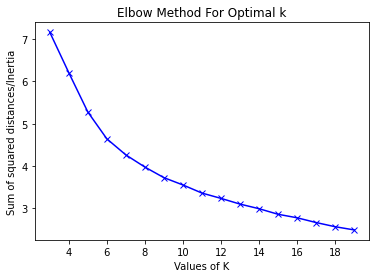

In [8]:
Sum_of_squared_distances = []
K = range(3, 20)
for clust_num in K:
    kmeans = KMeans(n_clusters=clust_num, random_state=2).fit(subset)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

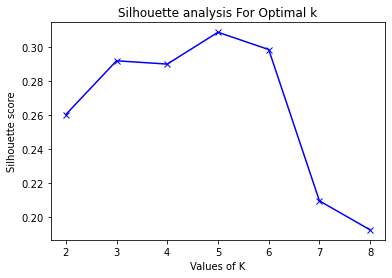

In [13]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in range_n_clusters:
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(subset)
    cluster_labels = kmeans.labels_
    # silhouette score
    silhouette_avg.append(silhouette_score(subset, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [20]:
fig = px.scatter(scat, x=list(labels.values())[0], y=list(labels.values())[1], color='cluster', hover_name=features.function, hover_data=features[['ID', 'mean', 'std']])
# make the figure bigger
plt.figure(figsize=(100, 10))
fig.update_traces(mode="markers")   
fig.show()

<Figure size 7200x720 with 0 Axes>

In [24]:
schools

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,w2,w3,w4,w5,w6,yearly,function,mean,std,ID
144,0.017364,0.017693,0.017451,0.019617,0.030990,0.051747,0.065150,0.066043,0.069596,0.070317,...,0.137312,0.184640,0.189721,0.053119,0.052023,167898.77,Lagere school,4.773989,4.691106,144
336,0.017770,0.017671,0.017589,0.017687,0.018661,0.027861,0.038627,0.052327,0.072701,0.080920,...,0.145385,0.183274,0.177775,0.062276,0.061845,176088.35,Lagere school,5.001796,5.258754,336
396,0.027249,0.027413,0.027838,0.028109,0.028489,0.032935,0.039862,0.048150,0.056112,0.063660,...,0.170091,0.161610,0.161048,0.086696,0.090362,170808.20,Lagere school,3.275853,3.882521,396
1216,0.024100,0.024196,0.024257,0.024283,0.024607,0.031096,0.045787,0.057618,0.067750,0.076676,...,0.154821,0.180597,0.164389,0.080030,0.077623,242780.46,Lagere school,6.240284,5.733109,1216
659,0.021283,0.021356,0.021335,0.021464,0.021831,0.021829,0.026208,0.041877,0.068158,0.079667,...,0.133474,0.183859,0.173999,0.077823,0.078995,259443.05,Lagere school,6.474463,7.380492,659
534,0.024278,0.024223,0.024485,0.024552,0.025208,0.036920,0.052018,0.059313,0.065958,0.067905,...,0.150048,0.172368,0.167972,0.085092,0.076000,457897.25,Lagere school,10.368307,7.997713,534
119,0.020468,0.020456,0.020752,0.022444,0.026098,0.033939,0.043871,0.056856,0.070734,0.072694,...,0.165600,0.183370,0.176833,0.056413,0.056406,135814.15,Lagere school,3.655874,3.498496,119
1503,0.016766,0.018206,0.020193,0.020973,0.022295,0.024430,0.027510,0.042228,0.072402,0.088105,...,0.136109,0.179612,0.181009,0.072385,0.069755,170753.50,Lagere school,4.412687,4.731969,1503
1109,0.028348,0.028258,0.028263,0.028308,0.028351,0.029197,0.032194,0.043678,0.060115,0.070439,...,0.159933,0.184624,0.172214,0.058306,0.058660,177972.05,Lagere school,7.071074,5.893168,1109
1238,0.017121,0.017185,0.017276,0.017312,0.017423,0.021873,0.040426,0.063747,0.077734,0.080007,...,0.156319,0.168359,0.170586,0.085260,0.069275,326885.55,Lagere school,10.249020,10.641204,1238


In [25]:
scat_schools = scat.loc[scat.function == 'Lagere school']

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,w4,w5,w6,weekend,evening,ID,cluster,function,mean,std
1208,0.029063,0.028680,0.028572,0.028642,0.028633,0.029271,0.035419,0.044136,0.051502,0.055081,...,0.148051,0.133553,0.104211,0.237764,0.186395,1208,0,Stadhuis/Gemeentehuis,9.313439,3.516002
588,0.037848,0.034725,0.030499,0.028053,0.025192,0.023478,0.024581,0.027429,0.032357,0.037106,...,0.147747,0.142086,0.121517,0.263603,0.259632,588,0,Academie,4.929265,4.023414
1116,0.028977,0.025676,0.024056,0.023490,0.023181,0.022967,0.023526,0.024884,0.028833,0.034342,...,0.123614,0.243310,0.203421,0.446731,0.315131,1116,0,Cultureel centrum,0.675075,1.535042
144,0.017364,0.017693,0.017451,0.019617,0.030990,0.051747,0.065150,0.066043,0.069596,0.070317,...,0.189721,0.053119,0.052023,0.105142,0.097103,144,2,Lagere school,4.773989,4.691106
510,0.014744,0.007901,0.004330,0.004037,0.006856,0.011406,0.013673,0.029621,0.062467,0.072689,...,0.148380,0.123754,0.114900,0.238654,0.284621,510,0,Andere gebouwen,1.146714,3.083926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.024128,0.023211,0.022013,0.021805,0.025018,0.024900,0.026935,0.038310,0.047993,0.052065,...,0.147289,0.156389,0.120595,0.276985,0.204255,56,0,Ontmoetingscentrum,4.722174,3.758550
13,0.025005,0.024656,0.024338,0.024243,0.024247,0.026615,0.032917,0.043306,0.056842,0.062189,...,0.133354,0.102400,0.100667,0.203067,0.199861,13,2,Administratief centrum,10.530915,5.580256
1660,0.031519,0.029519,0.026141,0.022525,0.022221,0.023814,0.028086,0.037164,0.051098,0.055678,...,0.148926,0.140697,0.130036,0.270733,0.233330,1660,0,Cultureel centrum,7.875420,4.729058
235,0.028868,0.027834,0.027769,0.027721,0.028707,0.030684,0.036100,0.060162,0.077363,0.074278,...,0.132398,0.082819,0.078364,0.161183,0.135206,235,2,Werkplaats,5.620527,4.201984


In [28]:
scat_schools = scat.loc[scat.function == 'Administratief centrum']
schools = features.loc[features.function == 'Administratief centrum']
fig = px.scatter(scat_schools, x=list(labels.values())[0], y=list(labels.values())[1], color='cluster', hover_name=schools.function, hover_data=schools[['ID', 'mean', 'std']])
# make the figure bigger
plt.figure(figsize=(100, 10))
# x axis scale
#plt.xlim([0])
fig.update_traces(mode="markers")   
fig.show()

<Figure size 7200x720 with 0 Axes>

In [7]:
# Show  value counts in the function column for each cluster
counts = scat.groupby('cluster').function.value_counts().sort_values(ascending=False).unstack().T
counts.loc[counts.sum(axis=1).sort_values(ascending=False).index]

cluster,0,1,2,3,4
function,,,,,
Sporthal,79.0,6.0,20.0,NaN,NaN
Andere gebouwen,69.0,8.0,13.0,2.0,1.0
Administratief centrum,26.0,NaN,55.0,NaN,1.0
Cultureel centrum,66.0,NaN,12.0,NaN,1.0
Ontmoetingscentrum,58.0,1.0,6.0,NaN,NaN
Lagere school,2.0,NaN,53.0,NaN,NaN
RVT/WZC/revalidatiecentrum,34.0,NaN,5.0,NaN,NaN
Stadhuis/Gemeentehuis,9.0,NaN,29.0,NaN,NaN
Werkplaats,7.0,NaN,23.0,NaN,NaN


In [8]:
day_p = pd.DataFrame()
# Create stanard profiles for each cluster
for k, clust in enumerate(range(clust_num)):
    for i, ID in enumerate(scat[scat.cluster == clust].index):
        #print(ID)
        if i == 0:
            agg = pd.read_csv('./data/buildings/' + str(ID) + '.csv', index_col=0, usecols=['ds','Power'], parse_dates=['ds'])
            agg = agg / agg['2019'].sum()
        else:
            agg[ID] = pd.read_csv('./data/buildings/' + str(ID) + '.csv', index_col=0, usecols=['ds','Power'], parse_dates=['ds'])
            agg[ID] = agg[ID] / agg['2019'][ID].sum()
    # drop the rows with any infinite values
    agg = agg[~np.isinf(agg).any(1)]
    # Create an average profile over columns
    agg = agg.mean(axis=1)
    # group by hour of the day and make an average
    agg = agg.groupby(agg.index.hour).mean()
    day_p[clust] = agg

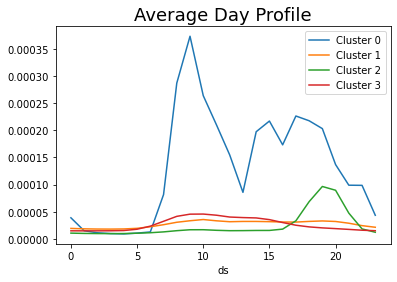

In [45]:
day_p.columns = ['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3', 'Cluster 4']
day_p.plot()
plt.title('Average Day Profile', fontsize=18)
plt.show()

In [46]:
weekly_p = pd.DataFrame()
# Create stanard profiles for each cluster
for k, clust in enumerate(range(clust_num)):
    for i, ID in enumerate(scat[scat.cluster == clust].index):
        #print(ID)
        if i == 0:
            agg = pd.read_csv('./data/buildings/' + str(ID) + '.csv', index_col=0, usecols=['ds','Power'], parse_dates=['ds'])
            agg = agg / agg['2019'].sum()
        else:
            agg[ID] = pd.read_csv('./data/buildings/' + str(ID) + '.csv', index_col=0, usecols=['ds','Power'], parse_dates=['ds'])
            agg[ID] = agg[ID] / agg['2019'][ID].sum()
    # drop the rows with any infinite values
    agg = agg[~np.isinf(agg).any(1)]
    # Create an average profile over columns
    agg = agg.mean(axis=1)
    # group by day of the week and take and average
    agg = agg.groupby(agg.index.weekday).mean()

In [ ]:
st_p = pd.DataFrame()
# Create stanard profiles for each cluster
for k, clust in enumerate(range(clust_num)):
    for i, ID in enumerate(scat[scat.cluster == clust].index):
        #print(ID)
        if i == 0:
            agg = pd.read_csv('./data/buildings/' + str(ID) + '.csv', index_col=0, usecols=['ds','Power'], parse_dates=['ds'])
            agg = agg / agg['2019'].sum()
        else:
            agg[ID] = pd.read_csv('./data/buildings/' + str(ID) + '.csv', index_col=0, usecols=['ds','Power'], parse_dates=['ds'])
            agg[ID] = agg[ID] / agg['2019'][ID].sum()
    # Create an average profile over columns
    agg = agg.mean(axis=1)
    st_p[clust] = agg